# Checkpoint 1

Importowanie bibliotek.

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from datetime import date
from collections import Counter
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

Wczytywanie danych.

In [22]:
gb_videos = pd.read_csv("data/GB_videos_5p.csv", sep=';', encoding= 'unicode_escape')
gb_category = pd.read_json("data/GB_category_id.json")
us_videos = pd.read_csv("data/US_videos_5p.csv", sep=';', encoding= 'unicode_escape')
us_category = pd.read_json("data/US_category_id.json")

Wstępne przetwarzanie danych

In [3]:
def change_date_format(df):
    data = df["trending_date"]
    data = data.split('.')
    data = list(map(int, data))
    if data[0] < 2000:
        data[0] += 2000
    return date(data[0], data[2], data[1])

gb_videos["trending_date"] = gb_videos.apply(lambda row: change_date_format(row), axis=1)
us_videos["trending_date"] = us_videos.apply(lambda row: change_date_format(row), axis=1)

## Wstępne statystyki

### Filmy z UK

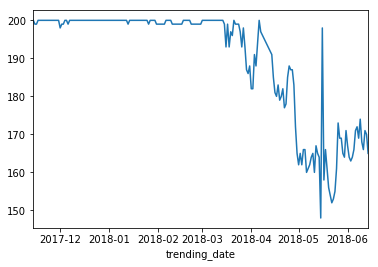

In [4]:
trending = gb_videos.groupby("trending_date")["trending_date"].count()
trending.plot()

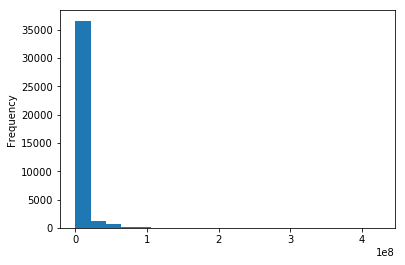

In [5]:
gb_videos["views"].plot.hist(bins=20)

(array([3.8788e+04, 7.1000e+01, 2.6000e+01, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 2.0000e+00, 4.0000e+00, 1.3000e+01, 8.0000e+00]),
 array([      0. ,  194497.1,  388994.2,  583491.3,  777988.4,  972485.5,
        1166982.6, 1361479.7, 1555976.8, 1750473.9, 1944971. ]),
 <a list of 10 Patch objects>)

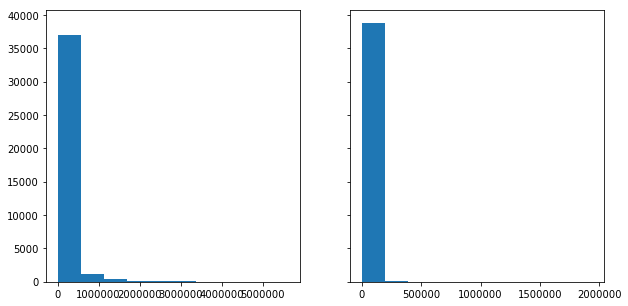

In [6]:
fig, ax = plt.subplots(1, 2, sharey="row", figsize=(10,5))

ax[0].hist(x=gb_videos["likes"], bins=10)
ax[1].hist(x=gb_videos["dislikes"], bins=10)

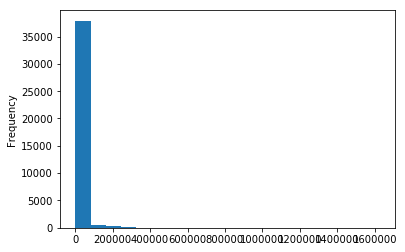

In [7]:
gb_videos["comment_count"].plot.hist(bins=20)

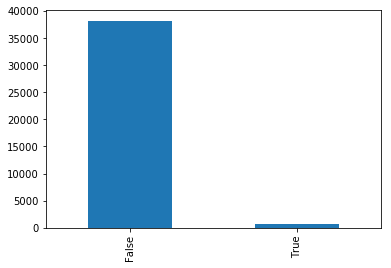

In [8]:
gb_videos["comments_disabled"].value_counts().plot.bar()

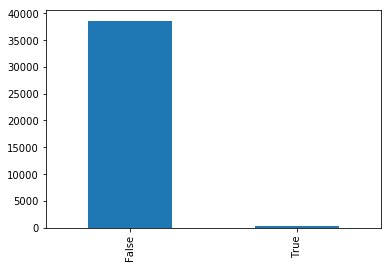

In [9]:
gb_videos["ratings_disabled"].value_counts().plot.bar()

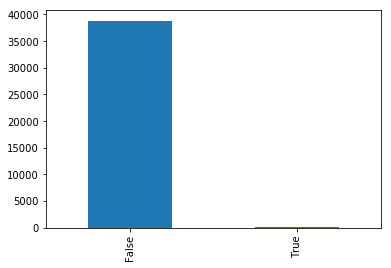

In [10]:
gb_videos["video_error_or_removed"].value_counts().plot.bar()

### Filmy z USA

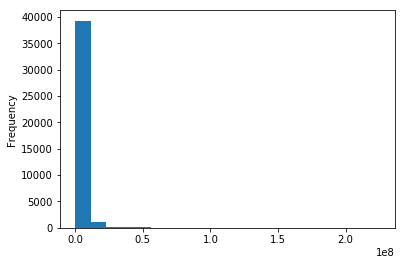

In [11]:
us_videos["views"].plot.hist(bins=20)

(array([4.0866e+04, 5.9000e+01, 1.0000e+01, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 3.0000e+00, 6.0000e+00]),
 array([      0.,  167442.,  334884.,  502326.,  669768.,  837210.,
        1004652., 1172094., 1339536., 1506978., 1674420.]),
 <a list of 10 Patch objects>)

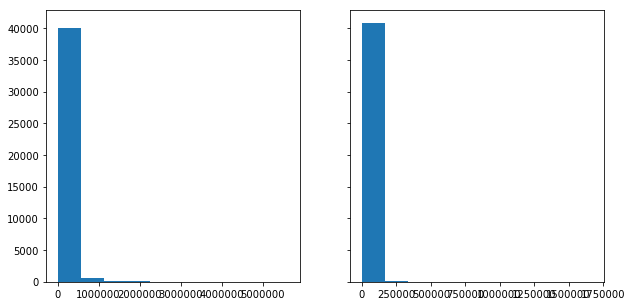

In [12]:
fig, ax = plt.subplots(1, 2, sharey="row", figsize=(10,5))

ax[0].hist(x=us_videos["likes"], bins=10)
ax[1].hist(x=us_videos["dislikes"], bins=10)

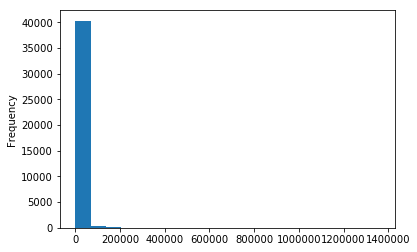

In [13]:
us_videos["comment_count"].plot.hist(bins=20)

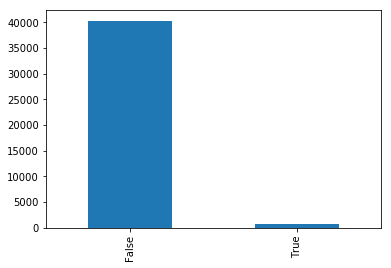

In [14]:
us_videos["comments_disabled"].value_counts().plot.bar()

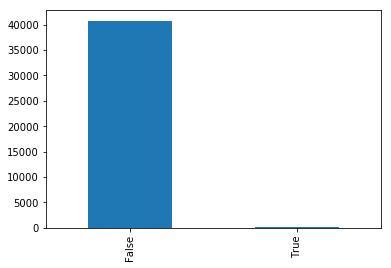

In [15]:
us_videos["ratings_disabled"].value_counts().plot.bar()

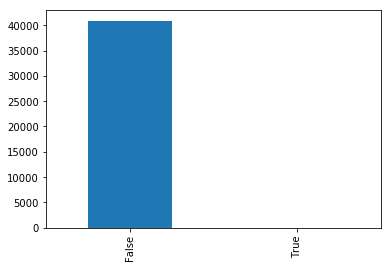

In [16]:
us_videos["video_error_or_removed"].value_counts().plot.bar()

## Zmiana reprezentacji danych

In [17]:
RE_HTTP = re.compile("http(s)?://[/\.a-z0-9]+")
RE_HASHTAG = re.compile("[@#][_a-z0-9]+")
RE_EMOTICONS = re.compile("(:-?\))|(:p)|(:d+)|(:-?\()|(:/)|(;-?\))|(<3)|(=\))|(\)-?:)|(:'\()|(8\))")
stopwords = ["a", "about", "after", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been",
            "before", "being", "between", "both", "by", "could", "did", "do", "does", "doing", "during", "each",
            "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here",
            "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've",
            "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "of",
            "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "own", "shan't", "she", "she'd",
            "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs",
            "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're",
            "they've", "this", "those", "through", "to", "until", "up", "very", "was", "wasn't", "we", "we'd",
            "we'll", "we're", "we've", "were", "weren't", "what", "what's", "when", "when's", "where", "where's",
            "which", "while", "who", "who's", "whom", "with", "would", "you", "you'd", "you'll", "you're", "you've",
            "your", "yours", "yourself", "yourselves", "above", "again", "against", "aren't", "below", "but", "can't",
            "cannot", "couldn't", "didn't", "doesn't", "don't", "down", "few", "hadn't", "hasn't", "haven't", "if",
            "isn't", "mustn't", "no", "nor", "not", "off", "out", "over", "shouldn't", "same", "too", "under", "why",
            "why's", "won't", "wouldn't"]

punctuation1 = "'*.,:;-_?!(){}[]<>"
punctuation2 = ["``", "''", "..."]

In [18]:
class BeforeTokenizationNormalizer():
    @staticmethod
    def normalize(text):
        text = text.strip().lower()
        text = text.replace('&nbsp;', ' ')
        text = text.replace('&lt;', '<')
        text = text.replace('&gt;', '>')
        text = text.replace('&amp;', '&')
        text = text.replace('&pound;', u'£')
        text = text.replace('&euro;', u'€')
        text = text.replace('&copy;', u'©')
        text = text.replace('&reg;', u'®')
        return text 

class SimpleTokenizer():
    @staticmethod
    def tokenize(text):
        return text.split(" ")
    
class NltkTokenizer():
    @staticmethod
    def tokenize(text):
        return nltk.word_tokenize(text) 
    
class Tokenizer():
    @staticmethod
    def tokenize(text):
        text = BeforeTokenizationNormalizer.normalize(text)
        tokens = SimpleTokenizer.tokenize(text)
        i = 0
        while i < len(tokens):
            token = tokens[i]
            match = None
            if (RE_HASHTAG.search(token)) or (RE_EMOTICONS.search(token)) or (RE_HTTP.search(token)):
                match = True
            if match is not None:
                pass
            else:
                del tokens[i]
                tokens[i:i] = NltkTokenizer.tokenize(token)
            i += 1
            
        porter = nltk.PorterStemmer()
        for i in range(len(tokens)):
            tokens[i] = porter.stem(tokens[i])
            
        tokens1 = []
        for ii in tokens:
            if (ii not in stopwords) and (ii not in punctuation1) and (ii not in punctuation2):
                tokens1.append(ii)
        return tokens1


In [23]:
gb_videos["description"] = gb_videos["description "].apply(lambda row: str(row))
gb_videos["description_tokens"] = gb_videos["description"].apply(lambda row: Tokenizer.tokenize(row.decode("utf-8")))
gb_videos["title_tokens"] = gb_videos["title"].apply(lambda row: Tokenizer.tokenize(row.decode("utf-8")))
gb_videos["tags_tokens"] = gb_videos["tags"].apply(lambda row: row.lower().replace('"', "").split("|"))

In [40]:
us_videos["description"] = us_videos["description "].apply(lambda row: str(row))
us_videos["description_tokens"] = us_videos["description"].apply(lambda row: Tokenizer.tokenize(row.decode("utf-8")))
us_videos["title_tokens"] = us_videos["title"].apply(lambda row: Tokenizer.tokenize(row.decode("utf-8")))
us_videos["tags_tokens"] = us_videos["tags"].apply(lambda row: row.lower().replace('"', "").split("|"))

In [41]:
wordsTitleGB = Counter()
wordsDescriptionGB = Counter()
wordsTagsGB = Counter()

for i in gb_videos["title_tokens"]:
    wordsTitleGB.update(i)

for i in gb_videos["description_tokens"]:
    wordsDescriptionGB.update(i)

for i in gb_videos["tags_tokens"]:
    wordsTagsGB.update(i)

In [42]:
wordsTitleUS = Counter()
wordsDescriptionUS = Counter()
wordsTagsUS = Counter()

for i in us_videos["title_tokens"]:
    wordsTitleUS.update(i)

for i in us_videos["description_tokens"]:
    wordsDescriptionUS.update(i)

for i in us_videos["tags_tokens"]:
    wordsTagsUS.update(i)

In [43]:
wordsTitleGB.most_common()

[(u'|', 8726),
 (u'offici', 6955),
 (u'video', 5896),
 (u'&', 3173),
 (u'trailer', 2755),
 (u"'s", 2611),
 (u'ft', 2518),
 (u'music', 1881),
 (u'2018', 1473),
 (u'audio', 1288),
 (u'feat', 1208),
 (u'star', 1194),
 (u'new', 1086),
 (u'war', 1075),
 (u'hd', 1072),
 (u'live', 1057),
 (u'last', 982),
 (u'2017', 926),
 (u'2', 792),
 (u'vs', 773),
 (u'movi', 695),
 (u'love', 691),
 (u'talk', 682),
 (u'(2018)', 679),
 (u'lyric', 678),
 (u'jedi', 661),
 (u'mv', 652),
 (u"n't", 633),
 (u'x', 632),
 (u'full', 624),
 (u'black', 602),
 (u'j', 566),
 (u'$', 544),
 (u'day', 542),
 (u'trump', 542),
 (u'remix', 535),
 (u'christma', 534),
 (u'like', 528),
 (u'cardi', 520),
 (u'1', 518),
 (u'perform', 514),
 (u'teaser', 500),
 (u'super', 495),
 (u'review', 492),
 (u'time', 483),
 (u'lil', 480),
 (u'jame', 479),
 (u'first', 479),
 (u'make', 476),
 (u'thi', 474),
 (u'b', 473),
 (u'season', 467),
 (u'hi', 461),
 (u'get', 451),
 (u'+', 448),
 (u'one', 445),
 (u'show', 437),
 (u'smith', 425),
 (u'game', 411

In [44]:
wordsDescriptionGB.most_common()

[(u'--', 39301),
 (u'video', 23165),
 (u"'s", 20203),
 (u'thi', 18473),
 (u'&', 16381),
 (u'music', 16272),
 (u'get', 12146),
 (u'new', 11352),
 (u'|', 10162),
 (u'offici', 10138),
 (u'subscrib', 9547),
 (u'show', 9124),
 (u'us', 8537),
 (u'hi', 8094),
 (u'\xe2\x80\x93', 7974),
 (u'facebook:', 7901),
 (u'twitter:', 7895),
 (u'watch', 7818),
 (u'follow', 7790),
 (u'like', 7664),
 (u'one', 7139),
 (u'instagram:', 7133),
 (u'live', 7076),
 (u'2018', 6969),
 (u'will', 6865),
 (u'now', 6818),
 (u'here:', 6771),
 (u'can', 6650),
 (u'star', 6537),
 (u'just', 6525),
 (u'wa', 6517),
 (u'make', 6257),
 (u'love', 6007),
 (u"n't", 5874),
 (u'channel', 5862),
 (u'late', 5818),
 (u'youtub', 5682),
 (u'know', 5638),
 (u'perform', 5592),
 (u'avail', 5389),
 (u'time', 5319),
 (u'use', 5315),
 (u'\xe2\x96\xba', 5307),
 (u'produc', 5026),
 (u'product', 5018),
 (u'want', 4962),
 (u'go', 4858),
 (u'na', 4810),
 (u'film', 4517),
 (u'come', 4454),
 (u'jimmi', 4438),
 (u'world', 4353),
 (u'night', 4337),
 (u'

In [45]:
wordsTagsGB.most_common()

[(u'funny', 3010),
 (u'comedy', 2920),
 (u'music', 2810),
 (u'pop', 2264),
 (u'[none]', 2010),
 (u'rap', 1750),
 (u'trailer', 1724),
 (u'music video', 1702),
 (u'official', 1596),
 (u'hip hop', 1510),
 (u'2018', 1383),
 (u'video', 1307),
 (u'interview', 1261),
 (u'live', 1167),
 (u'records', 1137),
 (u'humor', 1117),
 (u'celebrity', 1102),
 (u'star wars', 1102),
 (u'vlog', 1090),
 (u'movie', 1087),
 (u'official video', 1052),
 (u'film', 1022),
 (u'television', 946),
 (u'hollywood', 925),
 (u'the', 918),
 (u'late night', 872),
 (u'new', 871),
 (u'comedian', 846),
 (u'entertainment', 835),
 (u'talk show', 809),
 (u'fashion', 805),
 (u'christmas', 755),
 (u'2017', 754),
 (u'celebrities', 744),
 (u'marvel', 740),
 (u'news', 730),
 (u'review', 717),
 (u'atlantic records', 705),
 (u'jokes', 688),
 (u'beauty', 687),
 (u'dance', 686),
 (u'funny video', 682),
 (u'r&b', 679),
 (u'alternative', 655),
 (u'new york', 648),
 (u'clip', 637),
 (u'famous', 629),
 (u'movies', 624),
 (u'the last jedi', 6

In [46]:
wordsTitleUS.most_common()

[(u'|', 10663),
 (u'offici', 3980),
 (u"'s", 3646),
 (u'video', 2905),
 (u'trailer', 2255),
 (u'&', 2102),
 (u'2018', 1776),
 (u'ft', 1301),
 (u'make', 1067),
 (u'vs', 1046),
 (u'new', 946),
 (u'live', 938),
 (u'music', 894),
 (u'thi', 882),
 (u'makeup', 876),
 (u'2017', 862),
 (u'audio', 834),
 (u'hd', 793),
 (u'day', 779),
 (u"n't", 768),
 (u'2', 750),
 (u'get', 735),
 (u'game', 732),
 (u'first', 715),
 (u'tri', 691),
 (u'whi', 688),
 (u'star', 672),
 (u'show', 628),
 (u'$', 627),
 (u'challeng', 607),
 (u'full', 605),
 (u'lyric', 600),
 (u'movi', 581),
 (u'love', 579),
 (u'black', 564),
 (u'test', 534),
 (u'time', 527),
 (u'10', 526),
 (u'world', 523),
 (u'hi', 508),
 (u'war', 502),
 (u'one', 501),
 (u'season', 485),
 (u'talk', 480),
 (u'5', 475),
 (u'review', 465),
 (u'teaser', 461),
 (u'best', 460),
 (u'react', 457),
 (u'1', 440),
 (u'like', 436),
 (u'christma', 435),
 (u'look', 418),
 (u'will', 417),
 (u'life', 415),
 (u'super', 415),
 (u'jame', 406),
 (u'year', 404),
 (u'take', 3

In [47]:
wordsDescriptionUS.most_common()

[(u'--', 102762),
 (u'video', 29887),
 (u'thi', 28088),
 (u"'s", 27833),
 (u'follow', 23047),
 (u'subscrib', 18205),
 (u'get', 17543),
 (u'watch', 16270),
 (u'twitter:', 15927),
 (u'music', 15825),
 (u'&', 15122),
 (u'new', 14984),
 (u'instagram:', 14768),
 (u'like', 14635),
 (u'us', 14520),
 (u'facebook:', 14395),
 (u'|', 14108),
 (u'\xe2\x96\xba', 10797),
 (u'use', 10652),
 (u'make', 10618),
 (u'show', 10038),
 (u'here:', 9720),
 (u'product', 9000),
 (u'hi', 8803),
 (u'can', 8764),
 (u'wa', 8624),
 (u'channel', 7912),
 (u'check', 7826),
 (u'one', 7820),
 (u'youtub', 7613),
 (u'love', 7340),
 (u'thank', 7327),
 (u'offici', 7160),
 (u'see', 7158),
 (u'live', 7068),
 (u"n't", 6937),
 (u'will', 6921),
 (u'just', 6530),
 (u'find', 6513),
 (u'go', 6405),
 (u'news', 6330),
 (u'time', 6270),
 (u'world', 6238),
 (u'want', 6210),
 (u'know', 6107),
 (u'now', 6018),
 (u'first', 5836),
 (u'twitter', 5810),
 (u'late', 5739),
 (u'star', 5480),
 (u'film', 5413),
 (u'produc', 5290),
 (u'ha', 5175),
 

In [48]:
wordsTagsUS.most_common()

[(u'funny', 4142),
 (u'comedy', 3647),
 (u'how to', 1702),
 (u'music', 1664),
 (u'pop', 1634),
 (u'[none]', 1535),
 (u'trailer', 1413),
 (u'food', 1280),
 (u'2018', 1275),
 (u'news', 1254),
 (u'review', 1239),
 (u'makeup', 1238),
 (u'science', 1237),
 (u'humor', 1210),
 (u'celebrity', 1130),
 (u'diy', 1110),
 (u'tutorial', 1054),
 (u'video', 1031),
 (u'television', 1024),
 (u'live', 1020),
 (u'interview', 988),
 (u'vlog', 958),
 (u'entertainment', 951),
 (u'animation', 947),
 (u'beauty', 923),
 (u'movie', 908),
 (u'official', 896),
 (u'comedian', 879),
 (u'cooking', 864),
 (u'fun', 849),
 (u'hollywood', 847),
 (u'cute', 829),
 (u'buzzfeed', 804),
 (u'talk show', 788),
 (u'celebrities', 788),
 (u'late night', 783),
 (u'recipe', 778),
 (u'nbc', 760),
 (u'family friendly', 754),
 (u'sports', 752),
 (u'animals', 723),
 (u'best', 718),
 (u'music video', 712),
 (u'education', 711),
 (u'movies', 696),
 (u'fashion', 696),
 (u'challenge', 688),
 (u'records', 685),
 (u'2017', 676),
 (u'funny vid

In [49]:
AT_GB = gb_videos[["views", "likes", "dislikes", "comment_count", "comments_disabled", "ratings_disabled", "video_error_or_removed"]]

AT_GB["title_length"] = gb_videos["title"].apply(lambda row: len(row))
AT_GB["title_uppercase"] = gb_videos["title"].apply(lambda row: 1-float(len(''.join(x for x in row if not x.isupper())))/len(row))
AT_GB["title_emoticons"] = gb_videos["title"].apply(lambda row: RE_EMOTICONS.search(str(row))!=None)
AT_GB["title_hashtag"] = gb_videos["title"].apply(lambda row: RE_HASHTAG.search(str(row))!=None)
AT_GB["title_interpunction"] = gb_videos["title"].apply(lambda row: len(''.join(x for x in row if x in punctuation1)))
AT_GB["description_length"] = gb_videos["description"].apply(lambda row: len(str(row)))
AT_GB["description_uppercase"] = gb_videos["description"].apply(lambda row: 1-float(len(''.join(x for x in row if not x.isupper())))/len(row))
AT_GB["description_link"] = gb_videos["description"].apply(lambda row: RE_HTTP.search(row)!=None)
AT_GB["description_emoticons"] = gb_videos["description"].apply(lambda row: RE_EMOTICONS.search(row)!=None)
AT_GB["description_hashtag"] = gb_videos["description"].apply(lambda row: RE_HASHTAG.search(row)!=None)
AT_GB["description_interpunction"] = gb_videos["description"].apply(lambda row: len(''.join(x for x in row if x in punctuation1)))
AT_GB["tag_number"] = gb_videos["tags"].apply(lambda row: len(row.split("|")))

display(AT_GB)

,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,title_length,title_uppercase,title_emoticons,title_hashtag,title_interpunction,description_length,description_uppercase,description_link,description_emoticons,description_hashtag,description_interpunction,tag_number
0,7224515,55681,10247,9479,False,False,False,45,0.155556,False,False,1,802,0.048628,True,True,False,25,9
1,1053632,25561,2294,2757,False,False,False,43,0.186047,False,False,5,411,0.097324,True,True,False,35,36
2,17158579,787420,43420,125882,False,False,False,43,0.162791,False,False,4,580,0.050000,True,True,False,39,6
3,27833,193,12,37,False,False,False,76,0.105263,False,False,1,389,0.071979,True,True,False,21,9
4,9815,30,2,30,False,False,False,55,0.036364,False,False,1,147,0.040816,False,False,False,2,1
5,1182775,52708,1431,2333,False,False,False,28,0.142857,False,False,1,1020,0.061765,True,True,False,331,38
6,33523622,1634124,21082,85067,False,False,False,43,0.139535,False,False,3,1220,0.109836,True,True,False,63,10
7,1164201,57309,749,624,False,False,False,29,0.827586,False,False,0,748,0.161765,True,True,False,57,31
8,154494,2163,147,211,False,False,False,48,0.125000,False,False,3,466,0.038627,True,True,False,23,5
9,9548677,190084,15015,11473,False,False,False,60,0.133333,False,False,6,685,0.105109,True,True,False,53,17


In [50]:
AT_US = us_videos[["views", "likes", "dislikes", "comment_count", "comments_disabled", "ratings_disabled", "video_error_or_removed"]]

AT_US["title_length"] = us_videos["title"].apply(lambda row: len(row))
AT_US["title_uppercase"] = us_videos["title"].apply(lambda row: 1-float(len(''.join(x for x in row if not x.isupper())))/len(row))
AT_US["title_emoticons"] = us_videos["title"].apply(lambda row: RE_EMOTICONS.search(str(row))!=None)
AT_US["title_hashtag"] = us_videos["title"].apply(lambda row: RE_HASHTAG.search(str(row))!=None)
AT_US["title_interpunction"] = us_videos["title"].apply(lambda row: len(''.join(x for x in row if x in punctuation1)))
AT_US["description_length"] = us_videos["description"].apply(lambda row: len(str(row)))
AT_US["description_uppercase"] = us_videos["description"].apply(lambda row: 1-float(len(''.join(x for x in row if not x.isupper())))/len(row))
AT_US["description_link"] = us_videos["description"].apply(lambda row: RE_HTTP.search(row)!=None)
AT_US["description_emoticons"] = us_videos["description"].apply(lambda row: RE_EMOTICONS.search(row)!=None)
AT_US["description_hashtag"] = us_videos["description"].apply(lambda row: RE_HASHTAG.search(row)!=None)
AT_US["description_interpunction"] = us_videos["description"].apply(lambda row: len(''.join(x for x in row if x in punctuation1)))
AT_US["tag_number"] = us_videos["tags"].apply(lambda row: len(row.split("|")))

display(AT_US)

,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,title_length,title_uppercase,title_emoticons,title_hashtag,title_interpunction,description_length,description_uppercase,description_link,description_emoticons,description_hashtag,description_interpunction,tag_number
0,748374,57527,2966,15954,False,False,False,34,0.823529,False,False,0,1379,0.179840,True,True,False,85,1
1,2418783,97185,6146,12703,False,False,False,62,0.177419,False,False,3,615,0.055285,True,True,False,20,4
2,3191434,146033,5339,8181,False,False,False,53,0.150943,False,False,1,1143,0.119860,True,True,False,107,23
3,343168,10172,666,2146,False,False,False,32,0.125000,False,False,2,1380,0.067391,True,True,True,73,27
4,2095731,132235,1989,17518,False,False,False,24,0.500000,False,False,3,602,0.039867,True,True,False,35,14
5,119180,9763,511,1434,False,False,False,21,0.142857,False,False,0,1547,0.129282,True,True,False,106,7
6,2103417,15993,2445,1970,False,False,False,41,0.219512,False,False,1,489,0.106339,True,True,False,40,42
7,817732,23663,778,3432,False,False,False,35,0.114286,False,False,0,714,0.137255,True,True,True,39,13
8,826059,3543,119,340,False,False,False,65,0.169231,False,False,2,1276,0.149687,True,True,False,57,28
9,256426,12654,1363,2368,False,False,False,55,0.018182,False,False,0,2213,0.044284,True,True,True,135,20
